In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
import do_mpc
import pandas as pd

In [6]:
res = do_mpc.data.load_results('./results/001_kite.pkl')

phi = res['simulator']['_x', 'phi'].flatten()
theta = res['simulator']['_x', 'theta'].flatten()
u_tilde = res['simulator']['_u', 'u_tilde'].flatten()
psi = res['simulator']['_x', 'psi'].flatten()
E_0 = res['simulator']['_p', 'E_0'].flatten()
v_0 = res['simulator']['_p', 'v_0'].flatten()


nn_input = {'phi':phi, 'theta': theta, 'u_tilde': u_tilde}
nn_output = {'phi':phi, 'theta': theta, 'psi': psi,  'u_tilde': u_tilde, 'E_0': E_0, 'v_0': v_0}

nn_input_df = pd.DataFrame.from_dict(nn_input)
nn_output_df = pd.DataFrame.from_dict(nn_output)

nn_input_list = [nn_input_df]
nn_output_list = [nn_output_df]

## RNN I/O structure
All our recurrent neural networks are trained with the stateful setting **True**. The settings is explained [here](https://keras.io/examples/lstm_stateful/). In summary, after having trained on a given data sequence, we use the resulting hidden state to initialize the next sequence. This is beneficial, when a very long coherent sequence is chopped into chunks for training (due to memory restrictions). In practice this allows to train the network to incoroporate much older information than the horizon, as defined with `seq_length`, contains. 

The downside of stateful training is, that data pre-processing is becoming more complex, when using batches. 
In the code cell below, we are preparing the data for stateful training with `batch_size > 0`.

In [3]:
X = nn_input_df.to_numpy()
Y = nn_output_df.to_numpy()
nx = X.shape[1]
ny = Y.shape[1]

consecutive sequences for each batch.

# Create DNN:

In [4]:
n_layer = 4          # This includes the output layer. n_layer-1 is the number of hidden layers.
n_units = 70         # Number of units per hidden layer.  
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nx
model_param['n_out'] = ny
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss='mse', optimizer='Adam')

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 70)                280       
_________________________________________________________________
dense_1 (Dense)              (None, 70)                4970      
_________________________________________________________________
dense_2 (Dense)              (None, 70)                4970      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 426       
Total params: 10,646
Trainable params: 10,646
Non-trainable params: 0
_________________________________________________________________


In [5]:
history = model.fit(X, 
                    Y, 
                    batch_size=100, 
                    epochs=1000)

Train on 1500 samples
Epoch 1/1000
1500/1500 [==============================] - 0s 197us/sample - loss: 11.3936
Epoch 2/1000
1500/1500 [==============================] - 0s 23us/sample - loss: 7.6682
Epoch 3/1000
1500/1500 [==============================] - 0s 32us/sample - loss: 3.0164
Epoch 4/1000
1500/1500 [==============================] - 0s 35us/sample - loss: 0.8029
Epoch 5/1000
1500/1500 [==============================] - 0s 29us/sample - loss: 0.6306
Epoch 6/1000
1500/1500 [==============================] - 0s 23us/sample - loss: 0.5654
Epoch 7/1000
1500/1500 [==============================] - 0s 35us/sample - loss: 0.5118
Epoch 8/1000
1500/1500 [==============================] - 0s 56us/sample - loss: 0.4839
Epoch 9/1000
1500/1500 [==============================] - 0s 30us/sample - loss: 0.4565
Epoch 10/1000
1500/1500 [==============================] - 0s 25us/sample - loss: 0.4330
Epoch 11/1000
1500/1500 [==============================] - 0s 20us/sample - loss: 0.4117
Epoch 

1500/1500 [==============================] - 0s 26us/sample - loss: 0.0133
Epoch 93/1000
1500/1500 [==============================] - 0s 31us/sample - loss: 0.0128
Epoch 94/1000
1500/1500 [==============================] - 0s 30us/sample - loss: 0.0125
Epoch 95/1000
1500/1500 [==============================] - 0s 53us/sample - loss: 0.0128
Epoch 96/1000
1500/1500 [==============================] - 0s 18us/sample - loss: 0.0123
Epoch 97/1000
1500/1500 [==============================] - 0s 26us/sample - loss: 0.0120
Epoch 98/1000
1500/1500 [==============================] - 0s 22us/sample - loss: 0.0120
Epoch 99/1000
1500/1500 [==============================] - 0s 22us/sample - loss: 0.0124
Epoch 100/1000
1500/1500 [==============================] - 0s 24us/sample - loss: 0.0117
Epoch 101/1000
1500/1500 [==============================] - 0s 31us/sample - loss: 0.0117
Epoch 102/1000
1500/1500 [==============================] - 0s 40us/sample - loss: 0.0113
Epoch 103/1000
1500/1500 [======

1500/1500 [==============================] - 0s 20us/sample - loss: 0.0052
Epoch 184/1000
1500/1500 [==============================] - 0s 21us/sample - loss: 0.0050
Epoch 185/1000
1500/1500 [==============================] - 0s 26us/sample - loss: 0.0048
Epoch 186/1000
1500/1500 [==============================] - 0s 26us/sample - loss: 0.0049
Epoch 187/1000
1500/1500 [==============================] - 0s 26us/sample - loss: 0.0048
Epoch 188/1000
1500/1500 [==============================] - 0s 25us/sample - loss: 0.0048
Epoch 189/1000
1500/1500 [==============================] - 0s 23us/sample - loss: 0.0049
Epoch 190/1000
1500/1500 [==============================] - 0s 27us/sample - loss: 0.0048
Epoch 191/1000
1500/1500 [==============================] - 0s 24us/sample - loss: 0.0048
Epoch 192/1000
1500/1500 [==============================] - 0s 22us/sample - loss: 0.0048
Epoch 193/1000
1500/1500 [==============================] - 0s 22us/sample - loss: 0.0046
Epoch 194/1000
1500/1500 

1500/1500 [==============================] - 0s 26us/sample - loss: 0.0020
Epoch 275/1000
1500/1500 [==============================] - 0s 42us/sample - loss: 0.0021
Epoch 276/1000
1500/1500 [==============================] - 0s 41us/sample - loss: 0.0021
Epoch 277/1000
1500/1500 [==============================] - 0s 74us/sample - loss: 0.0020
Epoch 278/1000
1500/1500 [==============================] - 0s 48us/sample - loss: 0.0023
Epoch 279/1000
1500/1500 [==============================] - 0s 65us/sample - loss: 0.0022
Epoch 280/1000
1500/1500 [==============================] - 0s 30us/sample - loss: 0.0021
Epoch 281/1000
1500/1500 [==============================] - 0s 26us/sample - loss: 0.0021
Epoch 282/1000
1500/1500 [==============================] - 0s 25us/sample - loss: 0.0020
Epoch 283/1000
1500/1500 [==============================] - 0s 20us/sample - loss: 0.0020
Epoch 284/1000
1500/1500 [==============================] - 0s 16us/sample - loss: 0.0022
Epoch 285/1000
1500/1500 

1500/1500 [==============================] - 0s 19us/sample - loss: 0.0011
Epoch 366/1000
1500/1500 [==============================] - 0s 27us/sample - loss: 0.0011
Epoch 367/1000
1500/1500 [==============================] - 0s 30us/sample - loss: 0.0011
Epoch 368/1000
1500/1500 [==============================] - 0s 24us/sample - loss: 0.0010
Epoch 369/1000
1500/1500 [==============================] - 0s 35us/sample - loss: 0.0010
Epoch 370/1000
1500/1500 [==============================] - 0s 59us/sample - loss: 0.0010
Epoch 371/1000
1500/1500 [==============================] - 0s 47us/sample - loss: 0.0010
Epoch 372/1000
1500/1500 [==============================] - 0s 42us/sample - loss: 0.0010
Epoch 373/1000
1500/1500 [==============================] - 0s 28us/sample - loss: 0.0011
Epoch 374/1000
1500/1500 [==============================] - 0s 29us/sample - loss: 0.0017
Epoch 375/1000
1500/1500 [==============================] - 0s 48us/sample - loss: 0.0017
Epoch 376/1000
1500/1500 

Epoch 454/1000
1500/1500 [==============================] - 0s 41us/sample - loss: 9.4847e-04
Epoch 455/1000
1500/1500 [==============================] - 0s 65us/sample - loss: 7.8246e-04
Epoch 456/1000
1500/1500 [==============================] - 0s 46us/sample - loss: 0.0010
Epoch 457/1000
1500/1500 [==============================] - 0s 30us/sample - loss: 0.0012
Epoch 458/1000
1500/1500 [==============================] - 0s 53us/sample - loss: 0.0010
Epoch 459/1000
1500/1500 [==============================] - 0s 48us/sample - loss: 0.0011
Epoch 460/1000
1500/1500 [==============================] - 0s 42us/sample - loss: 8.1244e-04
Epoch 461/1000
1500/1500 [==============================] - 0s 34us/sample - loss: 9.1579e-04
Epoch 462/1000
1500/1500 [==============================] - 0s 76us/sample - loss: 9.4790e-04
Epoch 463/1000
1500/1500 [==============================] - 0s 53us/sample - loss: 8.7936e-04
Epoch 464/1000
1500/1500 [==============================] - 0s 45us/sample -

Epoch 541/1000
1500/1500 [==============================] - 0s 77us/sample - loss: 7.2319e-04
Epoch 542/1000
1500/1500 [==============================] - 0s 74us/sample - loss: 7.6790e-04
Epoch 543/1000
1500/1500 [==============================] - 0s 101us/sample - loss: 6.8770e-04
Epoch 544/1000
1500/1500 [==============================] - 0s 57us/sample - loss: 7.9283e-04
Epoch 545/1000
1500/1500 [==============================] - 0s 58us/sample - loss: 8.4370e-04
Epoch 546/1000
1500/1500 [==============================] - 0s 36us/sample - loss: 7.5053e-04
Epoch 547/1000
1500/1500 [==============================] - 0s 28us/sample - loss: 7.7660e-04
Epoch 548/1000
1500/1500 [==============================] - 0s 19us/sample - loss: 7.8544e-04
Epoch 549/1000
1500/1500 [==============================] - 0s 25us/sample - loss: 7.6244e-04
Epoch 550/1000
1500/1500 [==============================] - 0s 56us/sample - loss: 7.3806e-04
Epoch 551/1000
1500/1500 [==============================] -

1500/1500 [==============================] - 0s 14us/sample - loss: 6.8714e-04
Epoch 629/1000
1500/1500 [==============================] - 0s 20us/sample - loss: 6.3873e-04
Epoch 630/1000
1500/1500 [==============================] - 0s 15us/sample - loss: 5.9267e-04
Epoch 631/1000
1500/1500 [==============================] - 0s 18us/sample - loss: 5.8344e-04
Epoch 632/1000
1500/1500 [==============================] - 0s 12us/sample - loss: 5.8554e-04
Epoch 633/1000
1500/1500 [==============================] - 0s 15us/sample - loss: 5.6928e-04
Epoch 634/1000
1500/1500 [==============================] - 0s 13us/sample - loss: 6.6765e-04
Epoch 635/1000
1500/1500 [==============================] - 0s 13us/sample - loss: 5.8994e-04
Epoch 636/1000
1500/1500 [==============================] - 0s 17us/sample - loss: 5.7676e-04
Epoch 637/1000
1500/1500 [==============================] - 0s 12us/sample - loss: 5.9611e-04
Epoch 638/1000
1500/1500 [==============================] - 0s 13us/sample 

1500/1500 [==============================] - 0s 46us/sample - loss: 6.0778e-04
Epoch 716/1000
1500/1500 [==============================] - 0s 35us/sample - loss: 6.1246e-04
Epoch 717/1000
1500/1500 [==============================] - 0s 25us/sample - loss: 6.1838e-04
Epoch 718/1000
1500/1500 [==============================] - 0s 24us/sample - loss: 6.0672e-04
Epoch 719/1000
1500/1500 [==============================] - 0s 30us/sample - loss: 5.9596e-04
Epoch 720/1000
1500/1500 [==============================] - 0s 24us/sample - loss: 7.2792e-04
Epoch 721/1000
1500/1500 [==============================] - 0s 26us/sample - loss: 5.4388e-04
Epoch 722/1000
1500/1500 [==============================] - 0s 32us/sample - loss: 5.2008e-04
Epoch 723/1000
1500/1500 [==============================] - 0s 22us/sample - loss: 5.6282e-04
Epoch 724/1000
1500/1500 [==============================] - 0s 22us/sample - loss: 6.1644e-04
Epoch 725/1000
1500/1500 [==============================] - 0s 32us/sample 

1500/1500 [==============================] - 0s 21us/sample - loss: 5.1695e-04
Epoch 803/1000
1500/1500 [==============================] - 0s 20us/sample - loss: 6.7069e-04
Epoch 804/1000
1500/1500 [==============================] - 0s 17us/sample - loss: 7.2440e-04
Epoch 805/1000
1500/1500 [==============================] - 0s 23us/sample - loss: 6.3724e-04
Epoch 806/1000
1500/1500 [==============================] - 0s 18us/sample - loss: 5.4578e-04
Epoch 807/1000
1500/1500 [==============================] - 0s 19us/sample - loss: 5.6398e-04
Epoch 808/1000
1500/1500 [==============================] - 0s 13us/sample - loss: 4.8662e-04
Epoch 809/1000
1500/1500 [==============================] - 0s 13us/sample - loss: 5.2810e-04
Epoch 810/1000
1500/1500 [==============================] - 0s 16us/sample - loss: 4.3701e-04
Epoch 811/1000
1500/1500 [==============================] - 0s 15us/sample - loss: 5.2435e-04
Epoch 812/1000
1500/1500 [==============================] - 0s 13us/sample 

1500/1500 [==============================] - 0s 12us/sample - loss: 5.0156e-04
Epoch 890/1000
1500/1500 [==============================] - 0s 13us/sample - loss: 5.3809e-04
Epoch 891/1000
1500/1500 [==============================] - 0s 13us/sample - loss: 4.9564e-04
Epoch 892/1000
1500/1500 [==============================] - 0s 14us/sample - loss: 4.9982e-04
Epoch 893/1000
1500/1500 [==============================] - 0s 12us/sample - loss: 5.4262e-04
Epoch 894/1000
1500/1500 [==============================] - 0s 12us/sample - loss: 4.5212e-04
Epoch 895/1000
1500/1500 [==============================] - 0s 12us/sample - loss: 5.0941e-04
Epoch 896/1000
1500/1500 [==============================] - 0s 12us/sample - loss: 4.6846e-04
Epoch 897/1000
1500/1500 [==============================] - 0s 21us/sample - loss: 4.2111e-04
Epoch 898/1000
1500/1500 [==============================] - 0s 15us/sample - loss: 4.5241e-04
Epoch 899/1000
1500/1500 [==============================] - 0s 16us/sample 

1500/1500 [==============================] - 0s 13us/sample - loss: 4.8400e-04
Epoch 977/1000
1500/1500 [==============================] - 0s 17us/sample - loss: 4.8624e-04
Epoch 978/1000
1500/1500 [==============================] - 0s 15us/sample - loss: 4.1975e-04
Epoch 979/1000
1500/1500 [==============================] - 0s 13us/sample - loss: 3.9849e-04
Epoch 980/1000
1500/1500 [==============================] - 0s 12us/sample - loss: 3.9214e-04
Epoch 981/1000
1500/1500 [==============================] - 0s 12us/sample - loss: 4.5962e-04
Epoch 982/1000
1500/1500 [==============================] - 0s 16us/sample - loss: 3.8233e-04
Epoch 983/1000
1500/1500 [==============================] - 0s 14us/sample - loss: 3.6583e-04
Epoch 984/1000
1500/1500 [==============================] - 0s 13us/sample - loss: 5.1580e-04
Epoch 985/1000
1500/1500 [==============================] - 0s 13us/sample - loss: 4.9593e-04
Epoch 986/1000
1500/1500 [==============================] - 0s 13us/sample 

# Evaluate Model


In [10]:
test_with = 0
nn_input_test = nn_input_list[test_with]


res = []

for i,in_i in nn_input_test.iterrows():
    nn_in = in_i.to_numpy()
    nn_out = model.predict(nn_in.reshape(1,-1))
    res.append(nn_out)
res = np.concatenate(res, axis=0).squeeze()

In [11]:
res_df = pd.DataFrame(res, columns = nn_output.keys())

Text(0, 0.5, 'v_0')

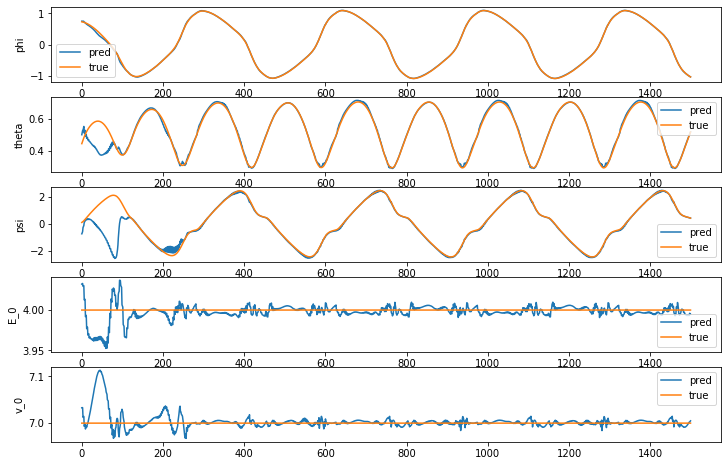

In [12]:
fig, ax = plt.subplots(5, figsize=(12,8))

res_df.plot(y=['phi'], ax=ax[0], label=['pred'])
nn_output_df.plot(y=['phi'], ax=ax[0], label=['true'])
ax[0].set_ylabel('phi')

res_df.plot(y=['theta'], ax=ax[1], label=['pred'])
nn_output_df.plot(y=['theta'], ax=ax[1], label=['true'])
ax[1].set_ylabel('theta')

res_df.plot(y=['psi'], ax=ax[2], label=['pred'])
nn_output_df.plot(y=['psi'], ax=ax[2], label=['true'])
ax[2].set_ylabel('psi')

res_df.plot(y=['E_0'], ax=ax[3], label=['pred'])
nn_output_df.plot(y=['E_0'], ax=ax[3], label=['true'])
ax[3].set_ylabel('E_0')

res_df.plot(y=['v_0'], ax=ax[4], label=['pred'])
nn_output_df.plot(y=['v_0'], ax=ax[4], label=['true'])
ax[4].set_ylabel('v_0')